In [1]:
!pip install transformers
#update scikit-learn
!pip uninstall scikit-learn -y
!pip install scikit-learn
from transformers import pipeline

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
  Using cached scikit_learn-1.0.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.2 MB)


In [2]:
# this classifier is not working well at all, returns same probabilities for all classes.
#classifier = pipeline("zero-shot-classification",
                      #model="gsarti/scibert-nli")

In [3]:
# get biomimicry papers
import pandas as pd
url = 'https://raw.githubusercontent.com/nasa-petal/search-engine/main/golden.json'
df = pd.read_json(url, orient='columns')
df.head(10)

,paper,mag,venue_mag,author,reference,title,abstract,petalID,doi,venue,level1,level2,level3,url,isBiomimicry,fullDocLink,isOpenAccess,abstract_full,title_full
0,2103410568,"['bubble nest', 'nest', 'mixing', 'bubble', 'p...",['Biology Letters'],"[2346835213, 2098042950]","[2130285640, 2066345165, 2054319467, 204771406...","['building', 'home', 'foam', 'tungara', 'frog'...","['frogs', 'build', 'foam', 'nests', 'floating'...",0,10.1098/RSBL.2009.0934,"[""Weird Nature: An Astonishing Exploration of ...","['physically_assemble/disassemble', 'protect_f...","['physically_assemble_structure', 'protect_fro...","['protect_from_animals', 'protect_from_loss_of...",https://royalsocietypublishing.org/doi/10.1098...,Y,https://royalsocietypublishing.org/doi/10.1098...,True,Frogs that build foam nests floating on water ...,Building a home from foam—túngara frog foam ne...
1,2138292607,"['sunset', 'earth s magnetic field', 'compass'...",['Proceedings of the National Academy of Scien...,"[2132083079, 2425702268, 2552946098]","[1493129647, 2037761037, 1984592609, 213699427...","['nocturnal', 'mammal', 'greater', 'mouse', 'e...","['evidence', 'suggests', 'bats', 'detect', 'ge...",1,10.1073/PNAS.0912477107,['Proceedings of the National Academy of Scien...,['sense_send_or_process_information'],['sense_signals/environmental_cues'],['sense_spatial_awareness/balance/orientation'],https://www.pnas.org/content/107/15/6941,Y,https://www.pnas.org/content/107/15/6941.full.pdf,True,Recent evidence suggests that bats can detect ...,"A nocturnal mammal, the greater mouse-eared ba..."
2,2005539166,"['sepia mestus', 'optomotor response', 'cuttle...",['The Journal of Experimental Biology'],"[2163942483, 3088803717]","[2035108601, 2155571491, 2159857711, 207521876...","['polarization', 'sensitivity', 'two', 'specie...","['existence', 'polarization', 'sensitivity', '...",2,10.1242/JEB.042937,"['The Journal of Experimental Biology', 'Curre...",['sense_send_or_process_information'],['sense_signals/environmental_cues'],"['sense_light_in_the_non-visible_spectrum', 's...",https://jeb.biologists.org/content/213/19/3364,Y,https://journals.biologists.com/jeb/article-pd...,True,SUMMARY The existence of polarization sensitiv...,Polarization sensitivity in two species of cut...
3,2151557512,"['energy source', 'cellulase', 'archaea', 'cel...",['Nature Communications'],"[3146712807, 3146712807, 2189911855, 265906908...","[2141885858, 2120772351, 2108929776, 212024499...","['identification', 'characterization', 'multid...","['archaea', 'microorganisms', 'wide', 'range',...",3,10.1038/NCOMMS1373,['Nature Communications'],"['chemically_modify_or_change_energy_state', '...","['chemically_break_down', 'protect_from_non-li...","['chemically_break_down_organic_compounds', 'p...",https://www.nature.com/articles/ncomms1373,Y,https://www.nature.com/articles/ncomms1373.pdf,True,Despite extensive studies on microbial and enz...,Identification and characterization of a multi...
4,2160542693,"['galactan', 'coralline algae', 'cell wall', '...",['Journal of Phycology'],"[1790079306, 2557664461, 189902495, 2140516860]","[2001396309, 2057007315, 1968834637, 212515227...","['differences', 'polysaccharide', 'structure',...","['articulated', 'coralline', 'calliarthron', '...",4,10.1111/J.1529-8817.2010.00828.X,"['The Journal of Experimental Biology', 'Natur...",['maintain_structural_integrity'],['manage_structural_forces'],"['manage_shear', 'manage_stress/strain']",https://onlinelibrary.wiley.com/doi/abs/10.111...,Y,,False,The articulated coralline Calliarthron cheilos...,DIFFERENCES IN POLYSACCHARIDE STRUCTURE BETWEE...
5,2130285640,"['nest', 'peptide sequence', 'insect', 'cystat...",['Proceedings of The Royal Society B: Biologic...,"[2140984283, 2490734702, 2116739833, 2098042950]","[1975304761, 2089047063, 2034767282, 210406370...","['foam', 'nest', 'components', 'tungara', 'fro...","['foam', 'nests', 'tungara', 'frog', 'engystom...",5,10.1098/RSPB.2008.1939,"[""Weird Nature: An Astonishing Expl

In [4]:
# remap level1 labels
'''
df.level1 = df.level1.replace({'physically_assemble/disassemble' : 'physically assembling or disassembling',
                               'protect_from_harm':'protecting',
                               'sense_send_or_process_information':'sensing, sending or processing information',
                               'sense,_send,_or_process_information': 'sensing, sending or processing information',
                               'chemically_modify_or_change_energy_state':'chemically assembling or breaking down',
                               'maintain_structural_integrity':'managing mechanical forces',
                               'attach':'attaching',
                               'move':'movement',
                               'process_resources':'manipulating solids, liquids, gases or energy',
                               'sustain_ecological_community':'sustaining ecological community',
                               'maintain_ecological_community':'sustaining ecological community',
                               'manipulate_solids,_liquids,_gases,_or_energy':'manipulating solids, liquids, gases or energy',
                               'change_size_or_color':''}, regex=True)
'''
df.level1 = df.level1.replace({'physically_assemble/disassemble' : 'physically_assemble_or_disassemble',
                               'sense,_send,_or_process_information': 'sense_send_or_process_information',
                               'maintain_ecological_community':'sustain_ecological_community',
                               'manipulate_solids,_liquids,_gases,_or_energy':'manipulate_solids_liquids_gases_or_energy'}, regex=True)

In [5]:
# remove rows with no level1 labels, no paper ids, or no titles
df = df[df['level1'] != '[]']
df = df[df['level1'] != "['']"]
df = df[df['paper'] != '']
df = df[df['title'] != '']
df = df[df['title'] != '[]']
df = df[df['title'] != "['']"]
df = df[df['title_full'] != '']
df = df[df['title_full'] != '[]']
df = df[df['title_full'] != "['']"]
df

,paper,mag,venue_mag,author,reference,title,abstract,petalID,doi,venue,level1,level2,level3,url,isBiomimicry,fullDocLink,isOpenAccess,abstract_full,title_full
0,2103410568,"['bubble nest', 'nest', 'mixing', 'bubble', 'p...",['Biology Letters'],"[2346835213, 2098042950]","[2130285640, 2066345165, 2054319467, 204771406...","['building', 'home', 'foam', 'tungara', 'frog'...","['frogs', 'build', 'foam', 'nests', 'floating'...",0,10.1098/RSBL.2009.0934,"[""Weird Nature: An Astonishing Exploration of ...","['physically_assemble_or_disassemble', 'protec...","['physically_assemble_structure', 'protect_fro...","['protect_from_animals', 'protect_from_loss_of...",https://royalsocietypublishing.org/doi/10.1098...,Y,https://royalsocietypublishing.org/doi/10.1098...,True,Frogs that build foam nests floating on water ...,Building a home from foam—túngara frog foam ne...
1,2138292607,"['sunset', 'earth s magnetic field', 'compass'...",['Proceedings of the National Academy of Scien...,"[2132083079, 2425702268, 2552946098]","[1493129647, 2037761037, 1984592609, 213699427...","['nocturnal', 'mammal', 'greater', 'mouse', 'e...","['evidence', 'suggests', 'bats', 'detect', 'ge...",1,10.1073/PNAS.0912477107,['Proceedings of the National Academy of Scien...,['sense_send_or_process_information'],['sense_signals/environmental_cues'],['sense_spatial_awareness/balance/orientation'],https://www.pnas.org/content/107/15/6941,Y,https://www.pnas.org/content/107/15/6941.full.pdf,True,Recent evidence suggests that bats can detect ...,"A nocturnal mammal, the greater mouse-eared ba..."
2,2005539166,"['sepia mestus', 'optomotor response', 'cuttle...",['The Journal of Experimental Biology'],"[2163942483, 3088803717]","[2035108601, 2155571491, 2159857711, 207521876...","['polarization', 'sensitivity', 'two', 'specie...","['existence', 'polarization', 'sensitivity', '...",2,10.1242/JEB.042937,"['The Journal of Experimental Biology', 'Curre...",['sense_send_or_process_information'],['sense_signals/environmental_cues'],"['sense_light_in_the_non-visible_spectrum', 's...",https://jeb.biologists.org/content/213/19/3364,Y,https://journals.biologists.com/jeb/article-pd...,True,SUMMARY The existence of polarization sensitiv...,Polarization sensitivity in two species of cut...
3,2151557512,"['energy source', 'cellulase', 'archaea', 'cel...",['Nature Communications'],"[3146712807, 3146712807, 2189911855, 265906908...","[2141885858, 2120772351, 2108929776, 212024499...","['identification', 'characterization', 'multid...","['archaea', 'microorganisms', 'wide', 'range',...",3,10.1038/NCOMMS1373,['Nature Communications'],"['chemically_modify_or_change_energy_state', '...","['chemically_break_down', 'protect_from_non-li...","['chemically_break_down_organic_compounds', 'p...",https://www.nature.com/articles/ncomms1373,Y,https://www.nature.com/articles/ncomms1373.pdf,True,Despite extensive studies on microbial and enz...,Identification and characterization of a multi...
4,2160542693,"['galactan', 'coralline algae', 'cell wall', '...",['Journal of Phycology'],"[1790079306, 2557664461, 189902495, 2140516860]","[2001396309, 2057007315, 1968834637, 212515227...","['differences', 'polysaccharide', 'structure',...","['articulated', 'coralline', 'calliarthron', '...",4,10.1111/J.1529-8817.2010.00828.X,"['The Journal of Experimental Biology', 'Natur...",['maintain_structural_integrity'],['manage_structural_forces'],"['manage_shear', 'manage_stress/strain']",https://onlinelibrary.wiley.com/doi/abs/10.111...,Y,,False,The articulated coralline Calliarthron cheilos...,DIFFERENCES IN POLYSACCHARIDE STRUCTURE BETWEE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2102365436,"['drag', 'tension', 'flow show', 'flow', 'mech...",['The Biological Bulletin'],[2110937531],"[1560068742, 2242856701, 2270256938, 215877915...","['sag', 'mediated', 'modulated', 'tension', 't...","['long', 'compliant', 'feeding', 'tentacles', ...",1125,10.2307/1542126,"[""Comparative Bi

In [6]:
#df['title_and_abstract_full'] = df['title_full'].astype(str) + df['abstract_full'].astype(str)
df['title_and_abstract_full'] = (df['title_full'].fillna('') + '. ' + df['abstract_full'].fillna('')).str.strip('. ')
df['word_count'] = df['title_and_abstract_full'].apply(lambda x: len(x.split()))
print('MAX  length title + abstract ==', df["word_count"].max())
print('MEAN length title + abstract ==', df["word_count"].mean())

MAX  length title + abstract == 835
MEAN length title + abstract == 195.70793950850663


In [7]:
# convert array strings to actual arrays
from ast import literal_eval
df['level1'] = df['level1'].apply(literal_eval)
df['title'] = df['title'].apply(literal_eval)
df['abstract'] = df['abstract'].apply(literal_eval)

# show unique level1 labels in the dataset
from itertools import chain

unique_lists_in_items = df.level1
set_of_items = set(chain(*unique_lists_in_items))
print(set_of_items)

{'chemically_modify_or_change_energy_state', 'process_resources', 'physically_assemble_or_disassemble', 'protect_from_harm', 'move', 'change_size_or_color', 'sustain_ecological_community', 'maintain_structural_integrity', 'sense_send_or_process_information', 'attach'}


In [8]:
'''
sequences_to_classify = [{"MAGID":2114147125,"abstract":"Evidence for self-cleaning in gecko setae. A tokay gecko can cling to virtually any surface and support its body mass with a single toe by using the millions of keratinous setae on its toe pads. Each seta branches into hundreds of 200-nm spatulae that make intimate contact with a variety of surface profiles. We showed previously that the combined surface area of billions of spatulae maximizes van der Waals interactions to generate large adhesive and shear forces. Geckos are not known to groom their feet yet retain their stickiness for months between molts. How geckos manage to keep their feet clean while walking about with sticky toes has remained a puzzle until now. Although self-cleaning by water droplets occurs in plant and animal surfaces, no adhesive has been shown to self-clean. In the present study, we demonstrate that gecko setae are a self-cleaning adhesive. Geckos with dirty feet recovered their ability to cling to vertical surfaces after only a few steps. Self-cleaning occurred in arrays of setae isolated from the gecko. Contact mechanical models suggest that self-cleaning occurs by an energetic disequilibrium between the adhesive forces attracting a dirt particle to the substrate and those attracting the same particle to one or more spatulae. We propose that the property of self-cleaning is intrinsic to the setal nanostructure and therefore should be replicable in synthetic adhesive materials in the future."},
                         {"MAGID":2055451617,"abstract":"The plant surface is by default flat, and development away from this default is thought to have some function of evolutionary advantage. Although the functions of many plant epidermal cells have been described, the function of conical epidermal cells, a defining feature of petals in the majority of insect-pollinated flowers, has not. The location and frequency of conical cells have led to speculation that they play a role in attracting animal pollinators. Snapdragon (Antirrhinum) mutants lacking conical cells have been shown to be discriminated against by foraging bumblebees. Here we investigated the extent to which a difference in petal surface structure influences pollinator behavior through touch-based discrimination. To isolate touch-based responses, we used both biomimetic replicas of petal surfaces and isogenic Antirrhinum lines differing only in petal epidermal cell shape. We show that foraging bumblebees are able to discriminate between different surfaces via tactile cues alone. We find that bumblebees use color cues to discriminate against flowers that lack conical cells--but only when flower surfaces are presented at steep angles, making them difficult to manipulate. This facilitation of physical handling is a likely explanation for the prevalence of conical epidermal petal cells in most flowering plants."},
                         {"MAGID":2005631208,"abstract":"In stark contrast to most aggressive predators, Dosidicus gigas (jumbo squids) do not use minerals in their powerful mouthparts known as beaks. Their beaks instead consist of a highly sclerotized chitinous composite with incremental hydration from the tip to the base. We previously reported l-3,4-dihydroxyphenylalanine (dopa)-histidine (dopa-His) as an important covalent cross-link providing mechanical strengthening to the beak material. Here, we present a more complete characterization of the sclerotization chemistry and describe additional cross-links from D. gigas beak. All cross-links presented in this report share common building blocks, a family of di-, tri-, and tetra-histidine-catecholic adducts, that were separated by affinity chromatography and high performance liquid chromatography (HPLC) and identified by tandem mass spectroscopy and proton nuclear magnetic resonance (1H NMR). The data provide additional insights into the unusually high cross-link density found in mature beaks. Furthermore, we propose both a low molecular weight catechol, and peptidyl-dopa, to be sclerotization agents of squid beak. This appears to represent a new strategy for forming hard tissue in animals. The interplay between covalent cross-linking and dehydration on the graded properties of the beaks is discussed."},
                         {"MAGID":156627570,"abstract":"As human activities continue to alter the global nitrogen cycle, the ability to predict the impact of increased nitrogen loading to freshwater systems is becoming more and more important. Nitrogen retention is of particular interest because it is through its combined processes (denitrification, nitrogen sedimentation and uptake by aquatic plants) that local and downstream nitrogen concentrations are reduced. Here, we compare the magnitude of nitrogen retention and its components in wetlands, lakes and rivers. We show that wetlands retain the highest proportion of total nitrogen loading, followed by lakes and then rivers. The differences in the proportion of N retained among systems is explained almost entirely by differences in water discharge. Denitrification is the primary mechanism of nitrogen retention, followed by nitrogen sedimentation and uptake by aquatic plants."},
                         {"MAGID":2076699264,"abstract":"Cooling is a significant end-use of energy globally and a major driver of peak electricity demand. Air conditioning, for example, accounts for nearly fifteen per cent of the primary energy used by buildings in the United States. A passive cooling strategy that cools without any electricity input could therefore have a significant impact on global energy consumption. To achieve cooling one needs to be able to reach and maintain a temperature below that of the ambient air. At night, passive cooling below ambient air temperature has been demonstrated using a technique known as radiative cooling, in which a device exposed to the sky is used to radiate heat to outer space through a transparency window in the atmosphere between 8 and 13¬†micrometres. Peak cooling demand, however, occurs during the daytime. Daytime radiative cooling to a temperature below ambient of a surface under direct sunlight has not been achieved because sky access during the day results in heating of the radiative cooler by the Sun. Here, we experimentally demonstrate radiative cooling to nearly 5¬†degrees Celsius below the ambient air temperature under direct sunlight. Using a thermal photonic approach, we introduce an integrated photonic solar reflector and thermal emitter consisting of seven layers of HfO2 and SiO2 that reflects 97 per cent of incident sunlight while emitting strongly and selectively in the atmospheric transparency window. When exposed to direct sunlight exceeding 850 watts per square metre on a rooftop, the photonic radiative cooler cools to 4.9¬†degrees Celsius below ambient air temperature, and has a cooling power of 40.1 watts per square metre at ambient air temperature. These results demonstrate that a tailored, photonic approach can fundamentally enable new technological possibilities for energy efficiency. Further, the cold darkness of the Universe can be used as a renewable thermodynamic resource, even during the hottest hours of the day."},
                         {"MAGID":1986827150,"abstract":"Autotomy refers to the voluntary shedding of a body part; a renowned example is tail loss among lizards as a response to attempted predation. Although many aspects of lizard tail autotomy have been studied, the detailed morphology and mechanism remains unclear. In the present study, we showed that tail shedding by the Tokay gecko (Gekko gecko) and the associated extracellular matrix (ECM) rupture were independent of proteolysis. Instead, lizard caudal autotomy relied on biological adhesion facilitated by surface microstructures. Results based on bio-imaging techniques demonstrated that the tail of Gekko gecko was pre-severed at distinct sites and that its structural integrity depended on the adhesion between these segments."},
                         {"MAGID":1983825491,"abstract":"Competition among males for access to reproductive opportunities is a central tenet of behavioural biology that has critical implications for studies of mating systems, sexual selection and the evolution of numerous phenotypic traits. Given the expectation that males should compete vigorously for access to females, it may at first seem paradoxical that males in some species cooperate to reproduce, often resulting in the apparent sacrifice of direct fitness by some members of these cooperative partnerships. Because this form of cooperation lies at the interface between natural, sexual and kin selection, studies of the adaptive consequences of male reproductive cooperation may yield important insights into how complex and sometimes conflicting selective pressures shape individual behaviour. Here, we define and review examples of reproductive cooperation among male animals. We take an integrative approach to reviewing the potential causes of maleemale cooperation, including potential adaptive hypotheses, ecological correlates, phylogenetic patterns and physiological mechanisms. The impact of male reproductive cooperation on sexual selection theory is also discussed. We conclude by outlining several important directions for future research, including efforts to improve understanding of the ecological and demographic contexts in which male reproductive cooperation occurs. Collectively, such analyses promise to improve our understanding of multiple fundamental concepts in evolutionary biology. 2013 The Authors. Published on behalf of The Association for the Study of Animal Behaviour by Elsevier Ltd. All rights reserved."}]
'''
candidate_labels = ['Attach', 'Attach permanently', 'Attach temporarily', 'Modify color or camouflage', 'Change structural color', 'Change chemical color or pigmentation', 'Camouflage or mimicry', 'Modify size shape or material properties', 'Change size or shape', 'Change material properties', 'Modify or convert energy', 'Modify or convert electrical energy', 'Modify or convert magnetic energy', 'Modify or convert chemical energy', 'Modify or convert mechanical energy', 'Modify or convert thermal energy', 'Modify or convert light energy', 'Assemble or break down structure', 'Physically assemble structure', 'Break down structure', 'Move on or through solids liquids or gases', 'Passive movement', 'Passively move through or on solids', 'Passively move through or on liquids', 'Passively move through gases', 'Passively move through or on granular media', 'Active movement', 'Actively move through or on solids', 'Actively move through or on liquids', 'Actively move through gases', 'Actively move through or on granular media', 'Protect from living or non-living threats', 'Protect from living threats', 'Protect from animals', 'Protect from plants', 'Protect from fungi', 'Protect from microbes', 'Protect from non-living threats', 'Protect from solids', 'Protect from excess liquids', 'Protect from loss of liquids', 'Protect from gases', 'Protect from wind', 'Protect from temperature', 'Protect from fire', 'Protect from ice', 'Protect from light', 'Protect from chemicals', 'Protect from radiation', 'Manage mechanical forces', 'Manage external forces', 'Manage impact', 'Regulate drag or turbulence', 'Manage stress or strain', 'Prevent buckling', 'Prevent fracture or rupture', 'Manage shear', 'Prevent or allow deformation', 'Prevent degradation', 'Prevent fatigue', 'Control erosion', 'Regulate wear', 'Sustain ecological community', 'Individual benefit', 'Regulate reproduction or growth', 'Self-replicate', 'Maintain homeostasis or equillibrium', 'Group benefit', 'Coordinate by self-organization', 'Cooperate within or between species', 'Compete within or between species', 'Manage environmental disturbances', 'Manage populations or habitats', 'Manage pests or diseases', 'Maintain biodiversity', 'Chemically assemble or break down', 'Chemically assemble', 'Chemically assemble inorganic compounds', 'Chemically assemble organic compounds', 'Self-assemble', 'Chemically break down', 'Chemically break down inorganic compounds', 'Chemically break down organic compounds', 'Sense send or process information', 'Send signals', 'Send light signals in the visible spectrum', 'Send light signals in the non-visible spectrum', 'Send sound signals', 'Send tactile signals', 'Send chemical signals', 'Send vibratory signals', 'Send electrical or magnetic signals', 'Process signals', 'Differentiate signal from noise', 'Convert signals', 'Respond to signals', 'Sense signals or environmental cues', 'Sense light in the visible spectrum', 'Sense light in the non-visible spectrum', 'Sense electricity or magnetism', 'Sense disease in a living system', 'Sense touch and mechanical forces', 'Sense chemicals', 'Sense atmospheric conditions', 'Sense sound or vibrations', 'Sense temperature cues', 'Sense motion', 'Sense spatial awareness or balance or orientation', 'Sense shape and or or pattern', 'Manipulate solids liquids gases or energy', 'Capture resources', 'Capture solids', 'Capture liquids', 'Capture gases', 'Capture energy', 'Absorb and or or filter resources', 'Absorb and or or filter solids', 'Absorb and or or filter liquids', 'Absorb and or or filter gases', 'Store resources', 'Store solids', 'Store liquids', 'Store gases', 'Store energy', 'Distribute or expel resources', 'Distribute or expel solids', 'Distribute or expel liquids', 'Distribute or expel gases', 'Distribute or expel energy', 'Detox or purify']
candidate_labels_leaves = []
candidate_labels_lvl1 = ['physically assembling or disassembling',
                         'protecting',
                         'sensing, sending or processing information',
                         'chemically assembling or breaking down',
                         'managing mechanical forces',
                         'attaching',
                         'movement',
                         'manipulating solids, liquids, gases or energy',
                         'sustaining ecological community']
candidate_labels_lvl1b = ['assembling',
                         'protecting',
                         'signals',
                         'chemical assembly',
                         'structural integrity',
                         'attaching',
                         'movement',
                         'purifying',
                         'ecological community']

#Define the class labels
#this is the list of labels we're currently using
candidate_labels_lvl1c = ['physically_assemble_or_disassemble',
                          'protect_from_harm',
                          'sense_send_or_process_information',
                          'chemically_modify_or_change_energy_state',
                          'maintain_structural_integrity',
                          'attach',
                          'move',
                          'process_resources',
                          'sustain_ecological_community',
                          'change_size_or_color']

In [9]:
# take 50 papers from each level1 label = 500 samples for labelling.
samples = []
sampling = df
print(sampling.shape)

for label in candidate_labels_lvl1c:
  docs_with_label = sampling[pd.DataFrame(sampling['level1'].tolist()).isin([label]).any(1).values]
  sample = docs_with_label.head(50) #.sample(n = 3) #[5:7]
  samples.append(sample)
  sampling = sampling.drop(sample.index)
  print(sampling.shape)
df_samples = pd.concat(samples)

(1058, 21)
(1008, 21)
(958, 21)
(908, 21)
(858, 21)
(808, 21)
(758, 21)
(708, 21)
(658, 21)
(608, 21)
(558, 21)


In [10]:
# add a column to our dataframe to hold our ground truth labels. A 1 means the paper had the label in the ground truth data, a 0 means it didn't.
y_true = []

for idx, sequence in df_samples.iterrows():
  row = []
  for label in candidate_labels_lvl1c:
    if (label in sequence['level1']):
      row.append(1)
    else:
      row.append(0)
  y_true.append(row)

df_samples['target_list'] = y_true

,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color
2103410568,1,1,0,0,0,0,0,0,0,0
2130285640,1,1,0,0,1,0,0,0,0,0
2052657884,1,0,0,0,1,0,1,1,0,0
2039799445,1,0,0,0,0,0,1,0,1,1
2133743025,1,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
2128823378,0,0,0,0,0,0,0,1,0,1
1996290428,1,1,0,0,0,0,0,0,0,1
1675132674,0,0,0,0,0,0,0,0,0,1
1986883107,0,1,0,0,0,0,0,0,0,1


In [11]:
# K-Fold setup

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

splits = list(kf.split(df_samples))

#for split in splits:
  #train = df_samples.iloc[split[0]]
  #test =  df_samples.iloc[split[1]]
  #print(train)
  #print(test)

In [13]:
# SCIBERT supervised model training and validation
# adapted from https://github.com/kyawkhaung/researcharticles/blob/main/classification/3%20Title%20and%20Abstract.ipynb

from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from IPython.core.debugger import set_trace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
MAX_LEN = 512 #835 is our max length title + abstract but scibert only allows 512
TRAIN_BATCH_SIZE = 8 #32
VALID_BATCH_SIZE = 4 #32
EPOCHS = 5 #4
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

In [24]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['title_and_abstract_full']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [25]:
# Split data sample into train and test
split = splits[0]
df_train = df_samples.iloc[split[0]]
df_test =  df_samples.iloc[split[1]]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


print("FULL Dataset: {}".format(df_samples.shape))
print("TRAIN Dataset: {}".format(df_train.shape))
print("TEST Dataset: {}".format(df_test.shape))

training_set = CustomDataset(df_train, tokenizer, MAX_LEN)
test_set = CustomDataset(df_test, tokenizer, MAX_LEN)

FULL Dataset: (500, 22)
TRAIN Dataset: (400, 22)
TEST Dataset: (100, 22)


In [26]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

In [100]:
class SCIBERTClass(torch.nn.Module):
    def __init__(self):
        super(SCIBERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 10) # 10 for number of classes we want to predict
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = SCIBERTClass()
model.to(device)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SCIBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [101]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [29]:
val_targets=[]
# stores the predictions on the test set for each EPOCH.
val_outputs=[] 

def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      #save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model



In [30]:
#Train the model on the test set, and generate predictions on the test set.
checkpoint_path = None
best_model = None
trained_model = train_model(1, EPOCHS, np.Inf, training_loader, test_loader, model, 
                      optimizer,checkpoint_path,best_model)

# end SCIBERT supervised model training and validation

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.010248 	Average Validation Loss: 0.017672
Validation loss decreased (inf --> 0.017672).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.008768 	Average Validation Loss: 0.017655
Validation loss decreased (0.017672 --> 0.017655).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [33]:
# instantiate our pretrained zero-shot classifier
classifier2 = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [34]:
# generate scores for each label for each paper in the test set

col_scores = []
indexes = []

i = 1
total_samples = len(df_test.index)
for idx, sequence in df_test.iterrows():
  title_sentence = " ".join(sequence['title'])
  abs_sentence = " ".join(sequence['abstract'])
  sentence = title_sentence + " " + abs_sentence
  #sentence = sequence['title_full'] + " " + sequence['abstract_full']
  print('Predicting labels for document ', i, '/', total_samples)
  print(sentence)
  i += 1

  doc_scores = classifier2(sentence, candidate_labels_lvl1c, multi_label=True, device=device)
  row = []
  indexes.append(sequence['paper'])
  for label in candidate_labels_lvl1c:
    index = doc_scores['labels'].index(label)
    doc_score = doc_scores['scores'][index]
    row.append(doc_score)
  col_scores.append(row)

df_sys = pd.DataFrame(col_scores, index = indexes, columns = candidate_labels_lvl1c)
df_sys

Predicting labels for document  1 / 100
microtubule assembly dynamics nanoscale summary background labile nature microtubules critical establishing cellular morphology motility yet molecular basis assembly remains unclear optical tweezers track microtubule polymerization against microfabricated barriers permitting unprecedented spatial resolution find exhibit extensive nanometer scale variability growth rate undergo shortening excursions exceeding five tubulin layers periods overall net indicates guanosine triphosphate gtp cap exist single layer previously length increments over 100 ms time intervals n 16 762 small 0 81 6 60 nm mean standard deviation rarely exceed two dimer lengths indicating occurs almost exclusively via subunit addition rather oligomers recently suggested finally depends weakly load average decreasing 2 fold force increases 7 4 pn 8 conclusions data consistent mechanochemical model spatially extended allows substantial nanoscale still preventing complete catastrophe

,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color
2133743025,0.884220,0.852757,0.708512,0.534206,0.716606,0.724316,0.841705,0.630476,0.658450,0.617711
2003177396,0.076860,0.045121,0.874996,0.207911,0.039518,0.040510,0.281134,0.267736,0.245746,0.317729
2109831563,0.340400,0.922244,0.763243,0.295838,0.571562,0.751302,0.744579,0.689982,0.403855,0.839122
2092184130,0.021384,0.685070,0.183743,0.407096,0.199157,0.201795,0.355727,0.097007,0.399085,0.118556
2065920695,0.704910,0.615582,0.797389,0.468916,0.118950,0.393842,0.965287,0.307304,0.200053,0.327223
...,...,...,...,...,...,...,...,...,...,...
1871905688,0.759267,0.760535,0.792419,0.949111,0.552245,0.689042,0.853161,0.548310,0.530982,0.613681
1989018347,0.484803,0.815973,0.845538,0.842750,0.581736,0.735365,0.813812,0.816093,0.732262,0.589981
1972319369,0.137189,0.253785,0.516637,0.390718,0.056505,0.541110,0.773340,0.210224,0.094589,0.551009
1989699787,0.352603,0.544240,0.520625,0.653318,0.176588,0.660005,0.548641,0.394499,0.313355,0.693964


In [97]:
last_epoch_scores = val_outputs[-1 * len(df_test):]
df_sys_scibert = pd.DataFrame(last_epoch_scores, index = indexes, columns = candidate_labels_lvl1c)
print(len(last_epoch_scores))

100


In [88]:
# create our ground truth matrix D x T where row indexes are the paper MAGIDS, and the columns are the topics. A 1 means the paper had the label in the ground truth data, a 0 means it didn't.
y_true = []
indexes = []

for idx, sequence in df_test.iterrows():
  row = []
  indexes.append(sequence['paper'])
  for label in candidate_labels_lvl1c:
    if (label in sequence['level1']):
      row.append(1)
    else:
      row.append(0)
  y_true.append(row)

df_truth = pd.DataFrame(y_true, index = indexes, columns = candidate_labels_lvl1c)
df_truth

,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color
2133743025,1,0,0,0,0,0,1,0,1,1
2003177396,1,0,1,0,0,0,0,0,0,0
2109831563,1,1,1,0,0,0,0,0,0,0
2092184130,1,0,0,0,0,0,0,1,0,0
2065920695,1,0,0,0,0,0,1,0,1,1
2165284619,1,0,0,1,1,0,0,0,0,0
2610939633,1,0,0,0,1,0,0,0,0,0
1966293602,1,0,0,0,0,0,1,0,0,0
1966327407,1,0,0,0,0,0,0,0,0,1
2122127644,0,1,0,0,0,0,0,1,0,0


In [98]:
# generate Average Precision scores for each topic
from sklearn.metrics import (average_precision_score, precision_recall_curve, PrecisionRecallDisplay)
import matplotlib.pyplot as plt

y_true = np.array(y_true)
y_scores = np.array(col_scores)
y_scores_scibert = np.array(last_epoch_scores)

y_true_t = y_true.transpose()
y_scores_t = y_scores.transpose()
y_scores_scibert_t = y_scores_scibert.transpose()
ap_by_topic = []
ap_sb_by_topic = []
pr_by_topic = []
pr_sb_by_topic = []

for idx, topic in enumerate(y_true_t):
   ap = average_precision_score(topic, y_scores_t[idx])
   ap_scibert = average_precision_score(topic, y_scores_scibert_t[idx])
   precision, recall, _ = precision_recall_curve(topic, y_scores_t[idx])
   precision_sb, recall_sb, _ = precision_recall_curve(topic, y_scores_scibert_t[idx])
   ap_by_topic.append(ap)
   pr_by_topic.append([precision, recall])
   ap_sb_by_topic.append(ap_scibert)
   pr_sb_by_topic.append([precision_sb, recall_sb])

tmp = [ap_by_topic]
df_ap_by_topic = pd.DataFrame(tmp, columns = candidate_labels_lvl1c)

tmp2 = [ap_sb_by_topic]
df_ap_sb_by_topic = pd.DataFrame(tmp2, columns = candidate_labels_lvl1c)

# Generate MAP and gMAP scores
map = sum(ap_by_topic) / len(ap_by_topic)
map_sb = sum(ap_sb_by_topic) / len(ap_sb_by_topic)

multiply = 1
values = ap_by_topic
n = len(values)

for i in values:
    multiply = (multiply)*(i)

gmap = (multiply)**(1/n)

multiply = 1
values = ap_sb_by_topic
n = len(values)

for i in values:
    multiply = (multiply)*(i)

gmap_sb = (multiply)**(1/n)

print('bart-large-mnli evaluation results')
print(' MAP Score: ', map)
print('gMAP Score: ', gmap)
print('Average Precision by Class')
df_ap_by_topic

 MAP Score:  0.34188298279118456
gMAP Score:  0.3154406807783156
Average Precision by Class


,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color
0,0.194985,0.469633,0.208352,0.491365,0.220503,0.391087,0.502171,0.329119,0.449049,0.162566


In [99]:
print('scibert evaluation results')
print(' MAP Score: ', map_sb)
print('gMAP Score: ', gmap_sb)
print('Average Precision by Class')
df_ap_sb_by_topic

 MAP Score SciBERT:  0.47363989149954977
gMAP Score SciBERT:  0.421921881586089
Average Precision by Class


,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color
0,0.110277,0.216944,0.652504,0.413076,0.537635,0.461438,0.610175,0.433499,0.673882,0.626969


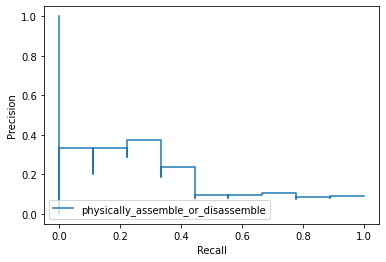

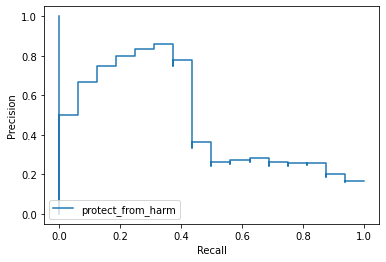

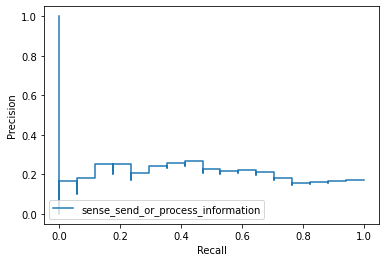

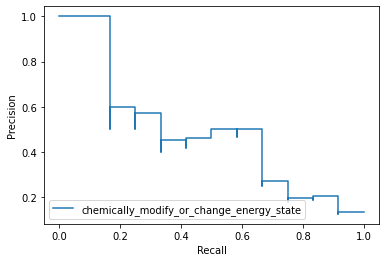

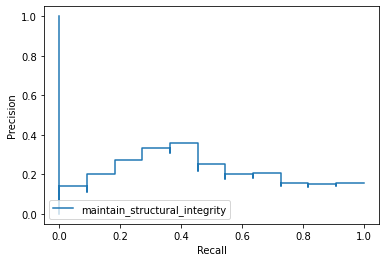

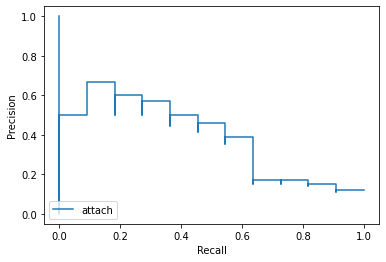

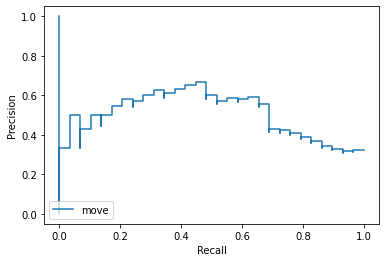

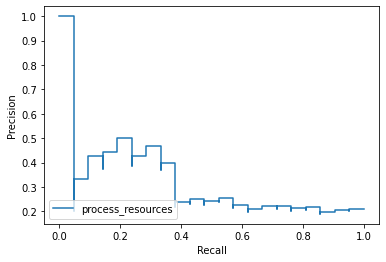

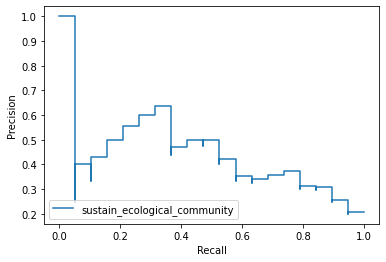

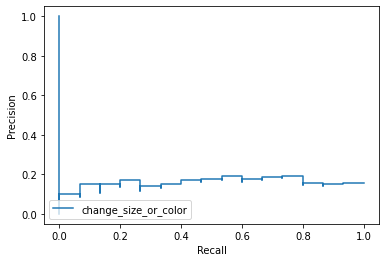

In [55]:
# PR curves for each topic - bart-large-mnli

i = 0

for pr in pr_by_topic:
  disp = PrecisionRecallDisplay(precision=pr[0], recall=pr[1])
  disp.plot(name=candidate_labels_lvl1c[i])
  i += 1

plt.show()

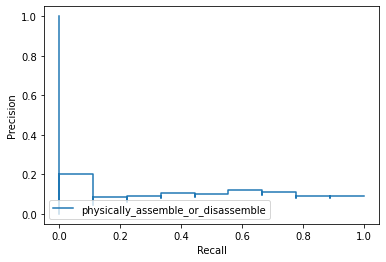

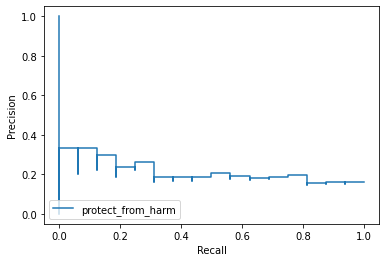

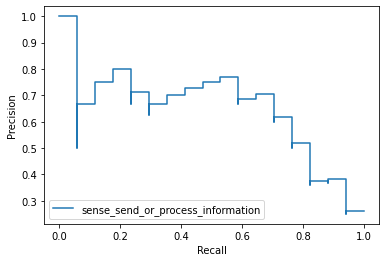

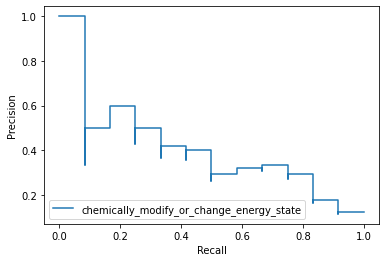

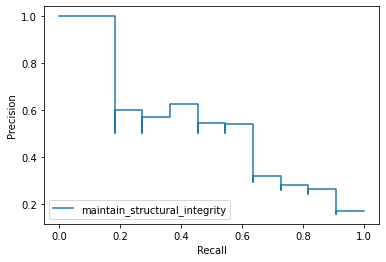

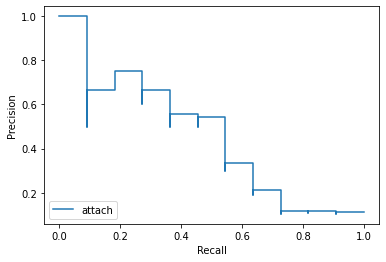

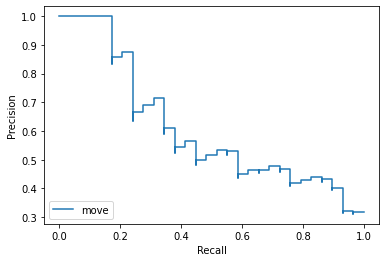

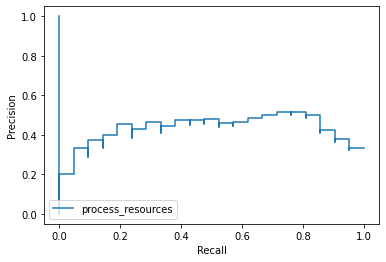

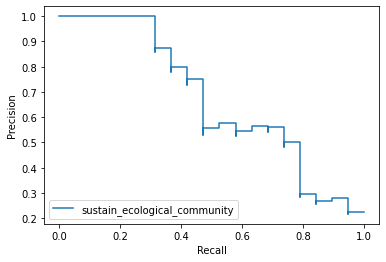

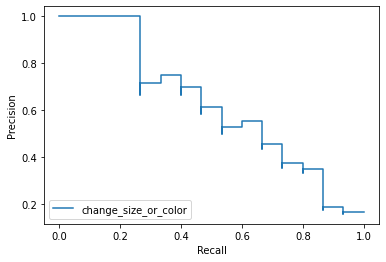

In [54]:
# PR curves for each topic - scibert
i = 0
for pr in pr_sb_by_topic:
  disp = PrecisionRecallDisplay(precision=pr[0], recall=pr[1])
  disp.plot(name=candidate_labels_lvl1c[i])
  i += 1

plt.show()

In [56]:
# bart-large-mnli: show the top k documents for each topic label. total_relevant are the total # of relevant documents for that label in the ground truth.

df_tmp = df_sys

topk = []
k = 10

for label in candidate_labels_lvl1c:
  df_tmp = df_tmp.sort_values(by=[label], ascending=False)
  i = 1
  total_rel = df_truth[label].sum()
  for idx, sequence in df_tmp.iterrows():
    title = df.loc[df['paper'] == idx,'title_full'].values[0]
    #title_sentence = " ".join(title)
    rel = df_truth.loc[idx,label]
    row = [label, idx, title, sequence[label], rel, total_rel]
    topk.append(row)
    i += 1
    if (i > k):
      break;
df_topk_by_topic = pd.DataFrame(topk, columns = ['label','MAGID','title','score','truly_relevant?', 'total_relevant'])
pd.set_option('display.max_rows', 300)
pd.set_option("max_colwidth", 150)
df_topk_by_topic

,label,MAGID,title,score,truly_relevant?,total_relevant
0,physically_assemble_or_disassemble,86187136,The cellulose system in viscin from mistletoe berries,0.981181,0,9
1,physically_assemble_or_disassemble,2016173006,"Abscission and dehiscence in the squirting cucumber, Ecballium elaterium. Regulation by ethylene",0.948993,0,9
2,physically_assemble_or_disassemble,2165284619,Xyloglucan endo-transglycosylase (XET) functions in gelatinous layers of tension wood fibers in poplar--a glimpse into the mechanism of the balanc...,0.901630,1,9
3,physically_assemble_or_disassemble,2131054331,Directional dependence of hydroxyapatite-collagen interactions on mechanics of collagen.,0.896470,0,9
4,physically_assemble_or_disassemble,2003258297,A conserved spider silk domain acts as a molecular switch that controls fibre assembly,0.886039,0,9
5,physically_assemble_or_disassemble,2133743025,Microtubule Assembly Dynamics at the Nanoscale,0.884220,1,9
6,physically_assemble_or_disassemble,1914407972,Mushrooms as Rainmakers: How Spores Act as Nuclei for Raindrops,0.874152,0,9
7,physically_assemble_or_disassemble,1966327407,The behavior in flow of the morphologically variable seaweed Hedophyllum sessile (C. Ag.) Setchell,0.823097,1,9
8,physically_assemble_or_disassemble,2132125170,Giant bent-core mesogens in the thread forming process of marine mussels.,0.800318,0,9
9,physically_assemble_or_disassemble,1996922079,"Competition for Space, Disturbance, and the Structure of a Benthic Stream Community",0.792482,0,9


In [57]:
# scibert: show the top k documents for each topic label. total_relevant are the total # of relevant documents for that label in the ground truth.

df_tmp = df_sys_scibert

topk = []
k = 10

for label in candidate_labels_lvl1c:
  df_tmp = df_tmp.sort_values(by=[label], ascending=False)
  i = 1
  total_rel = df_truth[label].sum()
  for idx, sequence in df_tmp.iterrows():
    title = df.loc[df['paper'] == idx,'title_full'].values[0]
    #title_sentence = " ".join(title)
    rel = df_truth.loc[idx,label]
    row = [label, idx, title, sequence[label], rel, total_rel]
    topk.append(row)
    i += 1
    if (i > k):
      break;
df_topk_sb_by_topic = pd.DataFrame(topk, columns = ['label','MAGID','title','score','truly_relevant?', 'total_relevant'])
pd.set_option('display.max_rows', 300)
pd.set_option("max_colwidth", 150)
df_topk_sb_by_topic

,label,MAGID,title,score,truly_relevant?,total_relevant
0,physically_assemble_or_disassemble,2008146383,Synaptotagmins: Why So Many?*,0.278490,0,9
1,physically_assemble_or_disassemble,86187136,The cellulose system in viscin from mistletoe berries,0.209756,0,9
2,physically_assemble_or_disassemble,2122127644,"Lymphatic vascular morphogenesis in development, physiology, and disease",0.201703,0,9
3,physically_assemble_or_disassemble,2132125170,Giant bent-core mesogens in the thread forming process of marine mussels.,0.201698,0,9
4,physically_assemble_or_disassemble,2065920695,Microtubule catastrophe and rescue.,0.197367,1,9
5,physically_assemble_or_disassemble,2149329003,"Sticking ability in Spix's disk-winged bat, Thyroptera tricolor (Microchiroptera: Thyropteridae)",0.192699,0,9
6,physically_assemble_or_disassemble,1871905688,Peptides controlling stifness of connective tissue in sea cucumbers.,0.192394,0,9
7,physically_assemble_or_disassemble,2003258297,A conserved spider silk domain acts as a molecular switch that controls fibre assembly,0.186510,0,9
8,physically_assemble_or_disassemble,2078225234,Plant hydraulics: The ascent of water,0.186247,0,9
9,physically_assemble_or_disassemble,1573736429,Biogeochemistry and microbial ecology of methane oxidation in anoxic environments: a review,0.184949,0,9
